# Importing Important Libraries

In [1]:
# Importing required libraries 
from urllib.request import urlopen
from zipfile import ZipFile

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, precision_score, recall_score, f1_score, classification_report

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense 
from keras.optimizers import Adam

# Data Preaparation

In [2]:
# Get files from google drive
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Extract Zip files
path= '/content/drive/MyDrive/santander-customer-transaction-prediction.zip'
with ZipFile(path, 'r') as zip:
  zip.printdir()

  print ('Extracting all Files')
  zip.extractall()  
  print ("Done")

File Name                                             Modified             Size
sample_submission.csv                          2019-12-11 22:00:08      2688905
test.csv                                       2019-12-11 22:00:12    301526706
train.csv                                      2019-12-11 22:01:00    302133017
Extracting all Files
Done


In [4]:
# Get Train and Test Data
train_data= pd.read_csv('/content/train.csv')
test_data= pd.read_csv('/content/test.csv')

In [5]:
train_data= train_data.sample(frac= 0.8, random_state=2022)
val_data= train_data.sample(frac= 0.2, random_state=2022)

In [6]:
X_train= np.asarray(train_data.drop(columns= ['target', 'ID_code'])).astype('float32')
X_train= pd.DataFrame(X_train)
y_train= np.array(train_data[['target']]).astype('float32')
y_train= pd.DataFrame(y_train)

X_test= np.asarray(test_data.drop(columns='ID_code')).astype('float32')
X_test= pd.DataFrame(X_test)

val_train= np.asarray(val_data.drop(columns= ['target', 'ID_code'])).astype('float32')
val_train= pd.DataFrame(val_train)
val_test= np.asarray(val_data[['target']]).astype('float32')
val_test= pd.DataFrame(val_test)

In [7]:
# Performing Scaling 
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_train= pd.DataFrame(X_train)

In [8]:
val_train = sc.transform(val_train)

# Exploratory Data Analysis

## Target Variable Distribution

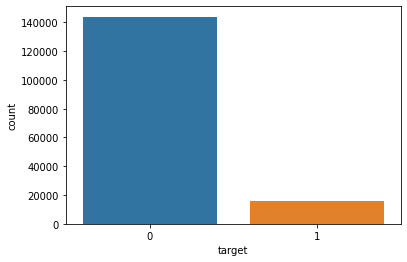

In [9]:
# Exploratory Data Analysis 
# Target variable Distribution
sns.countplot(x='target', data= train_data)
plt.show()

## PCA Clustering

In [10]:
pca = PCA(n_components= len(X_train.columns))
covar_matrix = pca.fit_transform(X_train)

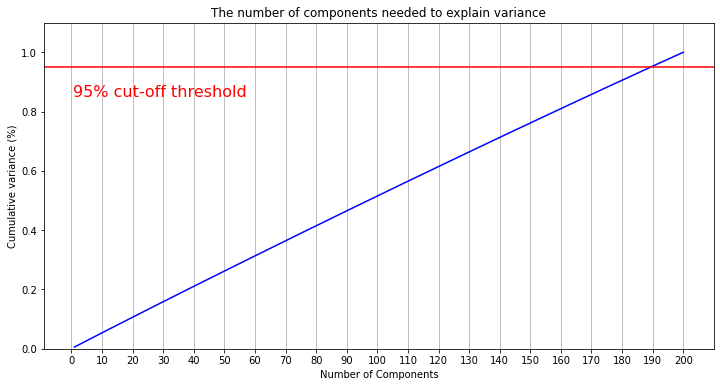

In [11]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 201, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 201, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

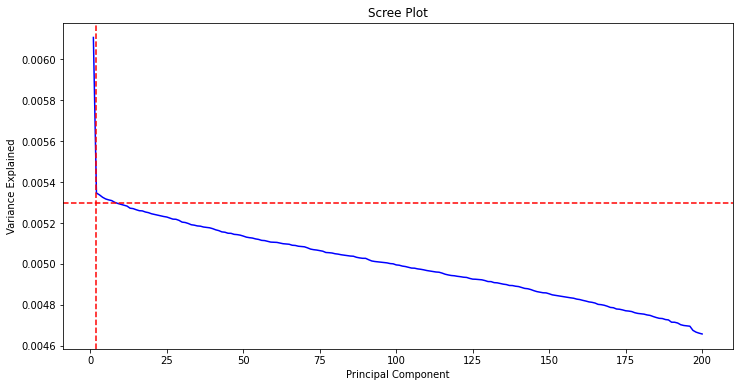

In [12]:
# Get desired no of principal components to be retrained

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.style.context('seaborn whitegrid')
plt.axhline(color='red', y=0.0053, linestyle= '--')
plt.axvline(color= 'red', x= 2, linestyle= '--')
plt.show()

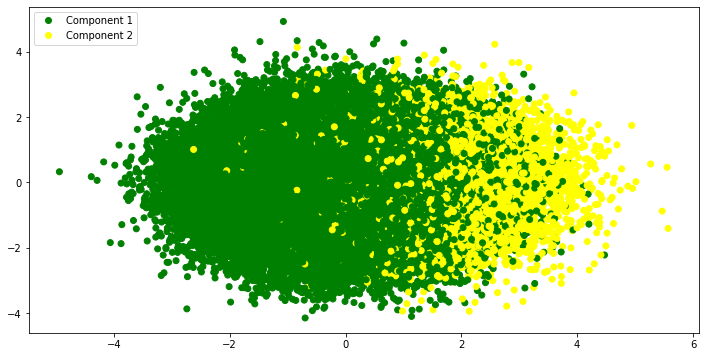

In [13]:
from matplotlib.colors import ListedColormap

# Visualiztion of the PCA 
classes= ['Component 1', 'Component 2']
tranformed_pca= pca.transform(X_train)
X_coord= tranformed_pca[:, 0]
y_coord= tranformed_pca[:, 1]
color= train_data['target']
cmap_colors= ListedColormap(['green', 'yellow'])
scatter= plt.scatter(X_coord, y_coord, c= color, cmap= cmap_colors)
plt.legend(loc='upper left', handles=scatter.legend_elements()[0], labels= classes)
plt.show()

## Summary Statisitcs 

In [14]:
# Summary Statistics
train_data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,...,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000
mean,0.100575,10.684479,-1.624314,10.716712,6.795003,11.077791,-5.073919,5.409748,16.545241,0.293741,...,3.234438,7.441633,1.927533,3.337128,18.000835,-0.142114,2.301855,8.908732,15.864380,-3.320135
std,0.300766,3.039944,4.047121,2.638508,2.044473,1.623032,7.860349,0.866831,3.419901,3.330962,...,4.563368,3.022043,1.478026,3.987536,3.131906,1.430340,5.447394,0.921640,3.011339,10.436956
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.385700,5.349700,-10.505500,...,-14.093300,-2.691700,-3.566800,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.458200,-4.737625,8.725675,5.251300,9.883900,-11.202450,4.767775,13.941275,-2.310625,...,-0.061600,5.161875,0.890000,0.594975,15.639750,-1.171400,-1.942050,8.253500,13.820675,-11.219100
50%,0.000000,10.532400,-1.604850,10.581450,6.825400,11.108100,-4.844850,5.385300,16.453800,0.412400,...,3.205800,7.353500,1.900200,3.398100,17.963650,-0.175250,2.411600,8.888900,15.924900,-2.811550
75%,0.000000,12.762925,1.358300,12.517425,8.322800,12.261600,0.915625,6.005300,19.100950,2.944125,...,6.405225,9.514500,2.948425,6.200925,20.401600,0.832200,6.555325,9.594600,18.061100,4.835725
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.128100,8.447700,27.691800,9.627200,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


## Co-relation co-efficients 

In [15]:
# Co-realtion coefficients 
var_corr= train_data.corr()
var_corr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052355,0.050271,0.055944,0.009950,0.011987,0.029343,0.066305,-0.002703,0.020071,...,0.055169,0.047729,-0.044748,-0.016104,-0.021292,0.028205,0.022630,-0.034095,-0.052910,0.023479
var_0,0.052355,1.000000,-0.001161,0.008129,0.004002,0.000421,0.005146,0.007438,0.001706,0.004791,...,-0.000303,-0.001066,-0.007476,0.000527,-0.000793,0.001673,0.003896,-0.000368,-0.006641,0.003958
var_1,0.050271,-0.001161,1.000000,0.004175,-0.001019,-0.000627,-0.000058,0.005128,-0.000746,0.002648,...,0.004712,0.003100,-0.003152,-0.000008,0.000042,-0.003373,0.000043,-0.003527,-0.005760,0.004011
var_2,0.055944,0.008129,0.004175,1.000000,0.000210,0.002493,-0.000156,0.000633,-0.001650,0.002360,...,0.000459,0.002231,-0.004274,0.002586,0.003666,-0.002002,0.003436,-0.000361,-0.000639,0.003198
var_3,0.009950,0.004002,-0.001019,0.000210,1.000000,-0.000659,0.000410,-0.001189,0.002258,0.004322,...,0.000462,0.002085,-0.000885,-0.001646,-0.001653,0.004417,-0.002625,0.001831,-0.002676,-0.000298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028205,0.001673,-0.003373,-0.002002,0.004417,0.004007,-0.000178,0.001528,0.002265,0.002362,...,0.004818,-0.001736,-0.004910,-0.001695,-0.004506,1.000000,0.003364,-0.005567,-0.000381,0.001602
var_196,0.022630,0.003896,0.000043,0.003436,-0.002625,-0.000879,0.002890,0.005036,0.000244,-0.004728,...,-0.002410,0.000917,-0.002569,-0.005459,-0.004428,0.003364,1.000000,-0.000709,0.000675,0.001619
var_197,-0.034095,-0.000368,-0.003527,-0.000361,0.001831,0.000417,0.000031,-0.004161,0.004798,-0.004938,...,-0.006264,0.001880,0.000141,0.004798,0.001485,-0.005567,-0.000709,1.000000,0.001733,0.006658
var_198,-0.052910,-0.006641,-0.005760,-0.000639,-0.002676,-0.003125,-0.001494,-0.001709,0.001965,0.003193,...,-0.000258,-0.000158,0.002820,-0.000706,0.003401,-0.000381,0.000675,0.001733,1.000000,-0.004176


In [16]:
index_names= var_corr.index.to_list()
def get_row_number(index_names):
  for index, index_name in enumerate(index_names):
    if index_name == 'target':
      return index

target_row= var_corr.iloc[[get_row_number(index_names)]]
target_row

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.0,0.052355,0.050271,0.055944,0.00995,0.011987,0.029343,0.066305,-0.002703,0.020071,...,0.055169,0.047729,-0.044748,-0.016104,-0.021292,0.028205,0.02263,-0.034095,-0.05291,0.023479


In [17]:
renamed_target_row= var_corr.set_index(var_corr.columns)
coeff_dataframe= renamed_target_row[['target']]
sorted_dataframe= coeff_dataframe.sort_values(by=['target'], ascending= False)
condition= sorted_dataframe['target']>0

sorted_dataframe['value']= np.where(condition, 'positively co-related features', 'negatively co-related features')
sorted_dataframe.head()

,target,value
target,1.000000,positively co-related features
var_6,0.066305,positively co-related features
var_26,0.065140,positively co-related features
var_110,0.063971,positively co-related features
var_53,0.063957,positively co-related features


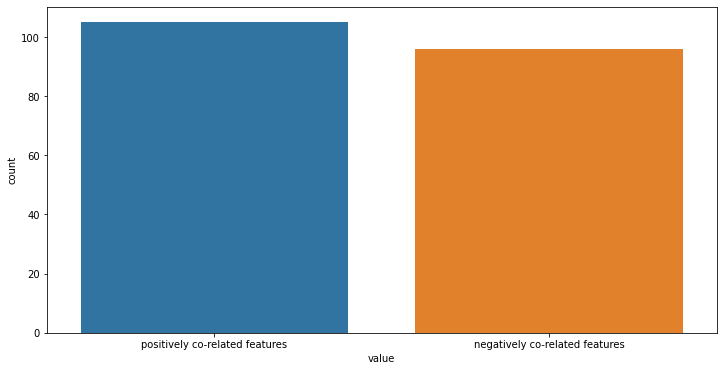

In [18]:
plot= sns.countplot(x= 'value', data= sorted_dataframe)
plt.show()

# Modelling

In [19]:
# Model architecture
input_dim= len(X_train.columns) # Get input dimensions equal to no of features

def train_model(nurons, epochs, batch_size, leanring_rate):
  model= Sequential()
  model.add(Dense(nurons, input_dim= input_dim, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  adam= Adam(learning_rate= leanring_rate)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, batch_size= batch_size, epochs= epochs, verbose= 1, validation_split= 0.33)
  return model

In [20]:
input_dim= len(X_train.columns)
def make_model(nurons):
    model = Sequential()
    model.add(Dense(nurons, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [21]:
# Modelling
nurons= 200
epochs= 100

model= make_model(nurons)
model.fit(X_train, y_train, epochs= 20, batch_size=256, validation_split=0.33)

Epoch 1/20
419/419 [==============================] - 7s 13ms/step - loss: 0.4343 - accuracy: 0.8189 - val_loss: 0.2461 - val_accuracy: 0.9119
Epoch 2/20
419/419 [==============================] - 5s 13ms/step - loss: 0.2613 - accuracy: 0.9051 - val_loss: 0.2349 - val_accuracy: 0.9128
Epoch 3/20
419/419 [==============================] - 5s 12ms/step - loss: 0.2452 - accuracy: 0.9088 - val_loss: 0.2338 - val_accuracy: 0.9130
Epoch 4/20
419/419 [==============================] - 5s 12ms/step - loss: 0.2406 - accuracy: 0.9095 - val_loss: 0.2338 - val_accuracy: 0.9123
Epoch 5/20
419/419 [==============================] - 5s 12ms/step - loss: 0.2365 - accuracy: 0.9108 - val_loss: 0.2334 - val_accuracy: 0.9134
Epoch 6/20
419/419 [==============================] - 7s 16ms/step - loss: 0.2338 - accuracy: 0.9109 - val_loss: 0.2340 - val_accuracy: 0.9123
Epoch 7/20
419/419 [==============================] - 5s 12ms/step - loss: 0.2316 - accuracy: 0.9116 - val_loss: 0.2351 - val_accuracy: 0.9118

# Predictions

In [22]:
# Predictions 
preds= model.predict(X_test)

6250/6250 [==============================] - 11s 2ms/step


In [23]:
predictions= np.select([preds>0.5, preds<0.5],[np.ones_like(preds), np.zeros_like(preds)])
test_data['Predicted Score']= predictions
test_data.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,Predicted Score
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,1.0
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,1.0
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,1.0
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,1.0
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0.0


# Model Validation

In [24]:
val_preds= model.predict(val_train)

1000/1000 [==============================] - 2s 2ms/step


In [25]:
valid_preds= np.select([val_preds> 0.5, val_preds <0.5], [1, 0])

In [26]:
val_test_flattened= np.asarray(val_test).flatten()
val_preds_flattened= np.asarray(valid_preds).flatten()

In [27]:
def get_eval_metrics(test, pred):
  print (f"Accuracy Score: {accuracy_score(test, pred)}")
  print (f"Precision Score: {precision_score(test, pred)}")
  print (f"Recall score: {recall_score(test, pred)}")
  print (f"F1-score:{f1_score(test, pred)}")
  print (f"Classification Report: {classification_report(test, pred)}")
  print ("Confusion Metrics:")
  cf= confusion_matrix(val_test_flattened, valid_preds)
  g= sns.heatmap(cf, annot=True, fmt= 'g')
  g.set_xlabel('Ground Truths')
  g.set_ylabel('Model Predictions')
  g.set_title('Confusion Matrix')
  display_labels= ['Zero', 'One']
  g.xaxis.set_ticklabels(display_labels)
  g.yaxis.set_ticklabels(display_labels)
  plt.show()

Accuracy Score: 0.92215625
Precision Score: 0.8180212014134276
Recall score: 0.2883836810962317
F1-score:0.42643334100851943
Classification Report:               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     28789
         1.0       0.82      0.29      0.43      3211

    accuracy                           0.92     32000
   macro avg       0.87      0.64      0.69     32000
weighted avg       0.92      0.92      0.90     32000

Confusion Metrics:


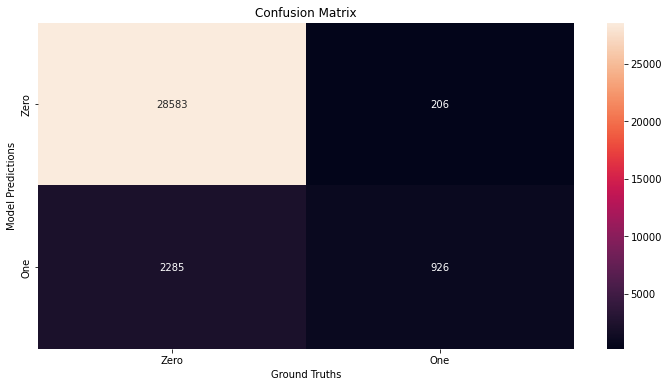

In [28]:
get_eval_metrics(val_test_flattened, val_preds_flattened)